# Домашнее задание 2. StarGAN

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r drive/MyDrive/gen_hw gen_hw
# !touch gen_hw/datasets/__init__.py
# !unzip gen_hw/data/celeba.zip -d gen_hw/data/
# !pip install lpips munch

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: gen_hw/data/__MACOSX/celeba/img_align_celeba/._179107.jpg  
  inflating: gen_hw/data/celeba/img_align_celeba/128348.jpg  
  inflating: gen_hw/data/__MACOSX/celeba/img_align_celeba/._128348.jpg  
  inflating: gen_hw/data/celeba/img_align_celeba/176552.jpg  
  inflating: gen_hw/data/__MACOSX/celeba/img_align_celeba/._176552.jpg  
  inflating: gen_hw/data/celeba/img_align_celeba/034013.jpg  
  inflating: gen_hw/data/__MACOSX/celeba/img_align_celeba/._034013.jpg  
  inflating: gen_hw/data/celeba/img_align_celeba/130507.jpg  
  inflating: gen_hw/data/__MACOSX/celeba/img_align_celeba/._130507.jpg  
  inflating: gen_hw/data/celeba/img_align_celeba/089592.jpg  
  inflating: gen_hw/data/__MACOSX/celeba/img_align_celeba/._089592.jpg  
  inflating: gen_hw/data/celeba/img_align_celeba/072046.jpg  
  inflating: gen_hw/data/__MACOSX/celeba/img_align_celeba/._072046.jpg  
  inflating: gen_hw/data/celeba/img_align_celeba/

## Этап 1. Установка зависимостей, инициализация и загрузка данных

В этом разделе мы работаем с датасетом CelebA, содержащим изображения лиц с набором атрибутов. Целью задания является генерация новых изображений лиц с заданными характеристиками.

In [2]:
# %pip install lpips -q

# import os
# os.chdir('gen_hw')

# import sys
# sys.path.append('./gen_hw')  # Добавляем путь к CelebADataset

import torch
from lpips import LPIPS
from torchvision import datasets, transforms
from munch import Munch
from tqdm.auto import trange
import matplotlib.pyplot as plt
import numpy as np
from datasets.celeba import CelebADataset

device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device)

In [3]:
args = Munch()
args.img_size = 256  # Размер изображений после преобразования

# Создание последовательности преобразований для подготовки изображений
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Загрузка датасета CelebA с применением указанных преобразований
dataset = CelebADataset(
    root_dir='data/celeba',
    transform=transform)

# Число потоков для загрузки данных
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# args.batch_size = ...   # Задайте размер батча
args.batch_size = 1

dataset_small = dataset

# Создание DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset_small,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

In [4]:
# args.num_domains = ...  # Задайте число доменов
args.num_domains = len(dataset.header)

### Визуализация датасета

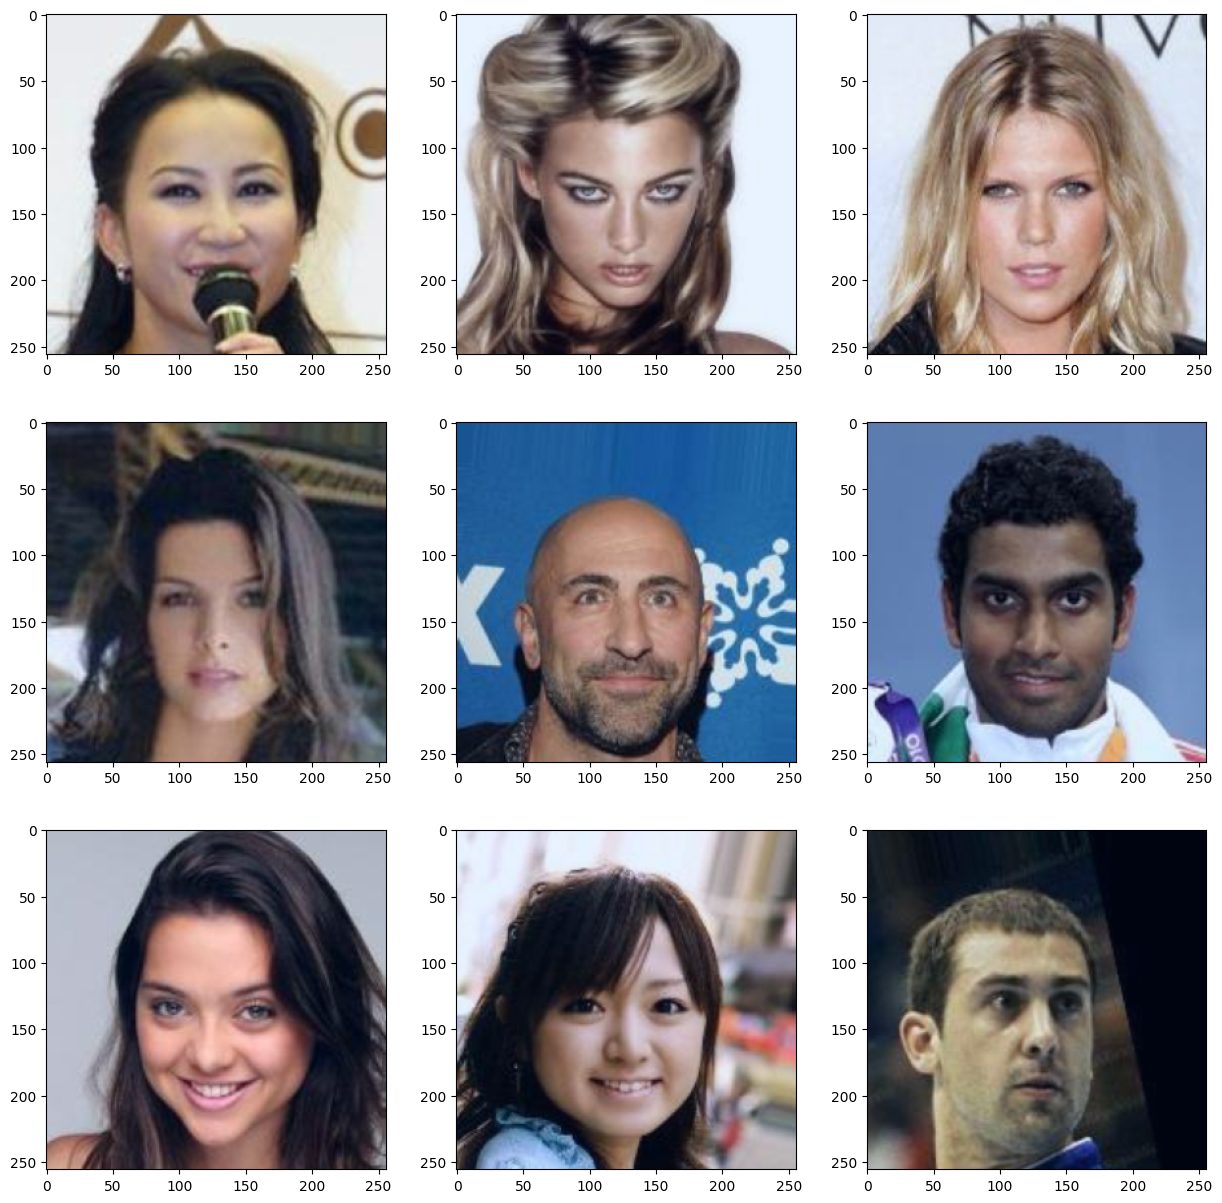

In [5]:
# Визуализация случайно выбранных изображений из датасета

_, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), 9)):

    img, target = dataset[img_idx]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i // 3][i % 3].imshow(img.detach().cpu().numpy().transpose(1, 2, 0))

## Этап 2. Инициализация и обучение модели

В этом этапе необходимо реализовать и обучить модель StarGAN для генерации лиц с заданными атрибутами.

Вы можете выбрать одну из следующих моделей:
- [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**)
- [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

### Инициализация

Ниже приведён шаблон для определения основных компонентов модели. Реализуйте их по своему усмотрению.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

In [7]:
args.latent_dim = 16
args.style_dim = 64

In [8]:
class AdaIN(nn.Module):
    def __init__(self, num_features, style_dim):
        super().__init__()
        # affine transform from style vector to gamma and beta
        self.fc = nn.Linear(style_dim, num_features * 2)
        nn.init.kaiming_normal_(self.fc.weight, nonlinearity='linear')

    def forward(self, x, s):
        # x: (B, C, H, W), s: (B, style_dim)
        params = self.fc(s)  # (B, 2*C)
        gamma, beta = params.chunk(2, dim=1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        # instance norm
        x_norm = F.instance_norm(x)
        return gamma * x_norm + beta


In [9]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, style_dim=None, use_adain=False, up=False, down=False):
        super().__init__()
        self.use_adain = use_adain
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU(inplace=True)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.down = down
        self.up = up
        if use_adain:
            assert style_dim is not None
            self.adain1 = AdaIN(out_ch, style_dim)
            self.adain2 = AdaIN(out_ch, style_dim)
        else:
            self.norm1 = nn.InstanceNorm2d(out_ch)
            self.norm2 = nn.InstanceNorm2d(out_ch)

    def forward(self, x, s=None):
        identity = x
        if self.up:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            identity = F.interpolate(identity, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        if self.use_adain:
            x = self.adain1(x, s)
        else:
            x = self.norm1(x)
        x = self.act(x)
        x = self.conv2(x)
        if self.use_adain:
            x = self.adain2(x, s)
        else:
            x = self.norm2(x)
        if self.down:
            x = F.avg_pool2d(x, 2)
            identity = F.avg_pool2d(identity, 2)
        return self.act(x + self.skip(identity))

In [10]:
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, hidden_dim=512, style_dim=64, num_domains=2):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        # unshared heads
        self.unshared = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, style_dim)
            ) for _ in range(num_domains)
        ])

    def forward(self, z, y):
        # z: (B, latent_dim), y: (B,) int tensor domain ids
        h = self.shared(z)
        out = torch.zeros((z.size(0), self.unshared[0][-1].out_features), device=z.device)
        for d in torch.unique(y):
            mask = (y == d)
            if mask.sum() == 0: continue
            out[mask] = self.unshared[int(d)](h[mask])
        return out


In [11]:
class StyleEncoder(nn.Module):
    def __init__(self, style_dim=64, num_domains=2):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(3, 64, 1),
            ResBlock(64, 128, style_dim=None, use_adain=False, down=True),
            ResBlock(128, 256, style_dim=None, use_adain=False, down=True),
            ResBlock(256, 512, style_dim=None, use_adain=False, down=True),
            ResBlock(512, 512, style_dim=None, use_adain=False, down=True),
            ResBlock(512, 512, style_dim=None, use_adain=False, down=True),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc_heads = nn.ModuleList([nn.Linear(512, style_dim) for _ in range(num_domains)])

    def forward(self, x, y):
        h = self.shared(x)
        h = self.pool(h).view(h.size(0), -1)  # (B, 512)
        out = torch.zeros((x.size(0), self.fc_heads[0].out_features), device=x.device)
        for d in torch.unique(y):
            mask = (y == d)
            if mask.sum() == 0: continue
            out[mask] = self.fc_heads[int(d)](h[mask])
        return out


In [12]:
class Generator(nn.Module):
    def __init__(self, style_dim=64, img_size=256):
        super().__init__()
        # encoder
        self.from_rgb = nn.Conv2d(3, 64, 1)
        self.enc1 = ResBlock(64, 128, use_adain=False, down=True)
        self.enc2 = ResBlock(128, 256, use_adain=False, down=True)
        self.enc3 = ResBlock(256, 512, use_adain=False, down=True)
        self.enc4 = ResBlock(512, 512, use_adain=False, down=True)
        # bottleneck
        self.mid1 = ResBlock(512, 512, use_adain=False)
        self.mid2 = ResBlock(512, 512, use_adain=False)
        # decoder with AdaIN injected
        self.dec1 = ResBlock(512, 512, style_dim=style_dim, use_adain=True, up=True)
        self.dec2 = ResBlock(512, 512, style_dim=style_dim, use_adain=True, up=True)
        self.dec3 = ResBlock(512, 256, style_dim=style_dim, use_adain=True, up=True)
        self.dec4 = ResBlock(256, 128, style_dim=style_dim, use_adain=True, up=True)
        self.to_rgb = nn.Conv2d(128, 3, 1)

    def forward(self, x, s):
        # x: (B,3,H,W), s: (B, style_dim)
        h = self.from_rgb(x)
        h = self.enc1(h)
        h = self.enc2(h)
        h = self.enc3(h)
        h = self.enc4(h)
        h = self.mid1(h, s=None)
        h = self.mid2(h, s=None)
        h = self.dec1(h, s)
        h = self.dec2(h, s)
        h = self.dec3(h, s)
        h = self.dec4(h, s)
        out = torch.tanh(self.to_rgb(h))
        return out


In [13]:
class Discriminator(nn.Module):
    def __init__(self, num_domains=2):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, 1),
            ResBlock(64, 128, use_adain=False, down=True),
            ResBlock(128, 256, use_adain=False, down=True),
            ResBlock(256, 512, use_adain=False, down=True),
            ResBlock(512, 512, use_adain=False, down=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.heads = nn.ModuleList([nn.Linear(512, 1) for _ in range(num_domains)])

    def forward(self, x, y):
        h = self.base(x)  # (B,512)
        out = torch.zeros((x.size(0), 1), device=x.device)
        for d in torch.unique(y):
            mask = (y == d)
            if mask.sum() == 0: continue
            out[mask] = self.heads[int(d)](h[mask])
        return out

In [14]:
# Создание структуры для хранения компонентов модели
# Раскомментируйте и реализуйте необходимые модули модели:

nets = Munch()
# Генератор, отвечающий за преобразование изображений
nets.generator = Generator(style_dim=args.style_dim, img_size=args.img_size).to(device)

# Сеть маппинга: преобразует латентный вектор в стиль
nets.mapping_network = MappingNetwork(latent_dim=args.latent_dim, style_dim=args.style_dim, num_domains=args.num_domains).to(device)

# Энкодер стиля: извлекает стиль из изображений
nets.style_encoder = StyleEncoder(style_dim=args.style_dim, num_domains=args.num_domains).to(device)

# Дискриминатор: оценивает реалистичность сгенерированных изображений
nets.discriminator = Discriminator(num_domains=args.num_domains).to(device)


### Обучение

In [15]:
# Ваш код

# --- Оптимайзеры ---
g_params = list(nets.generator.parameters()) + list(nets.mapping_network.parameters()) + list(nets.style_encoder.parameters())
d_params = list(nets.discriminator.parameters())
opt_g = torch.optim.Adam(g_params, lr=1e-4, betas=(0., 0.99))
opt_d = torch.optim.Adam(d_params, lr=1e-4, betas=(0., 0.99))

# --- Потери ---
adversarial_loss = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

def adv_loss_D(real_logits, fake_logits):
    real_target = torch.ones_like(real_logits)
    fake_target = torch.zeros_like(fake_logits)
    return adversarial_loss(real_logits, real_target) + adversarial_loss(fake_logits, fake_target)

def adv_loss_G(fake_logits):
    real_target = torch.ones_like(fake_logits)
    return adversarial_loss(fake_logits, real_target)

def style_recon_loss(s_real, s_pred):
    return l1(s_real, s_pred)

def diversity_loss(x1, x2):
    # encourage difference between outputs for different styles
    return -l1(x1, x2)  # negative because we maximize diversity (we'll subtract this term)


In [16]:
start_step = 0

In [17]:
# # колаб периодически крашится, поэтому продолжаем обучение с последнего чекпоинта
# ckpt = torch.load("../drive/MyDrive/gen_hw/full_checkpoint_100.pth", map_location=device)

# nets.mapping_network.load_state_dict(ckpt["mapping_network"])
# nets.style_encoder.load_state_dict(ckpt["style_encoder"])
# nets.generator.load_state_dict(ckpt["generator"])
# nets.discriminator.load_state_dict(ckpt["discriminator"])

# opt_g.load_state_dict(ckpt["opt_g"])
# opt_d.load_state_dict(ckpt["opt_d"])

# start_step = ckpt["step"]        # можно продолжать обучение


In [ ]:
def train_one_epoch(dataloader, n_iters=200):
    nets.generator.train()
    nets.mapping_network.train()
    nets.style_encoder.train()
    nets.discriminator.train()

    it = iter(dataloader)
    for i in range(start_step, n_iters):
        try:
            x_real, _ = next(it)
            x_ref, _ = next(it)
        except StopIteration:
            it = iter(dataloader)
            x_real, _ = next(it)
            x_ref, _ = next(it)

        x_real = x_real.to(device).float()
        x_ref = x_ref.to(device).float()

        batch_size = x_real.size(0)
        # randomly sample domains
        y_org = torch.randint(0, args.num_domains, (batch_size,), device=device)
        y_trg = torch.randint(0, args.num_domains, (batch_size,), device=device)
        # print(1)
        # --- D step ---
        # real logits (for their original domains)
        real_logits = nets.discriminator(x_real, y_org)
        z = torch.randn(batch_size, args.latent_dim, device=device)
        s_trg = nets.mapping_network(z, y_trg)
        x_fake = nets.generator(x_real, s_trg).detach()
        fake_logits = nets.discriminator(x_fake, y_trg)
        # print(2)
        d_loss = adv_loss_D(real_logits, fake_logits)
        opt_d.zero_grad()
        d_loss.backward()
        opt_d.step()
        # print(3)

        # --- G / F / E step ---
        z1 = torch.randn(batch_size, args.latent_dim, device=device)
        z2 = torch.randn(batch_size, args.latent_dim, device=device)
        s_trg1 = nets.mapping_network(z1, y_trg)
        s_trg2 = nets.mapping_network(z2, y_trg)
        x_fake1 = nets.generator(x_real, s_trg1)
        x_fake2 = nets.generator(x_real, s_trg2)
        # print(4)

        # adversarial
        fake_logits_g = nets.discriminator(x_fake1, y_trg)
        g_adv = adv_loss_G(fake_logits_g)
        # print(5)

        # style reconstruction: encode style from generated image and compare to target style
        s_pred = nets.style_encoder(x_fake1, y_trg)
        g_sty = style_recon_loss(s_trg1, s_pred)
        # print(6)

        # diversity sensitive (maximize L1 between two generated images for same input)
        g_div = l1(x_fake1, x_fake2)
        # print(7)

        # cycle consistency: reconstruct original using style encoded from x_real
        s_hat = nets.style_encoder(x_real, y_org)
        x_rec = nets.generator(x_fake1, s_hat)
        g_cyc = l1(x_real, x_rec)
        # print(8)

        lambda_sty = 1.0
        lambda_ds = 1.0
        lambda_cyc = 1.0

        g_loss = g_adv + lambda_sty * g_sty + (-lambda_ds) * g_div + lambda_cyc * g_cyc

        opt_g.zero_grad()
        g_loss.backward()
        opt_g.step()
        # print(9)

        print(f"Iter {i}: d_loss={d_loss.item():.4f} g_loss={g_loss.item():.4f} adv={g_adv.item():.4f} sty={g_sty.item():.4f} div={g_div.item():.4f} cyc={g_cyc.item():.4f}")
        if i % 10 == 0:
            torch.save({
                "mapping_network": nets.mapping_network.state_dict(),
                "style_encoder": nets.style_encoder.state_dict(),
                "generator": nets.generator.state_dict(),
                "discriminator": nets.discriminator.state_dict(),
                "opt_g": opt_g.state_dict(),
                "opt_d": opt_d.state_dict(),
                "step": i
            }, f"../drive/MyDrive/gen_hw/full_checkpoint_{i}.pth")


In [ ]:
train_one_epoch(dataloader, n_iters=300)

Iter 150: d_loss=1.2142 g_loss=1.7881 adv=1.1068 sty=0.0567 div=0.0034 cyc=0.6280
Iter 151: d_loss=1.1525 g_loss=2.0098 adv=1.3818 sty=0.0356 div=0.0007 cyc=0.5931
Iter 152: d_loss=2.2579 g_loss=1.1646 adv=0.5759 sty=0.0861 div=0.0004 cyc=0.5029
Iter 153: d_loss=0.8011 g_loss=2.4095 adv=1.2182 sty=0.0461 div=0.0005 cyc=1.1457
Iter 154: d_loss=1.3973 g_loss=1.4447 adv=0.8664 sty=0.0646 div=0.0007 cyc=0.5144
Iter 155: d_loss=1.3987 g_loss=1.6862 adv=1.0138 sty=0.0630 div=0.0007 cyc=0.6101
Iter 156: d_loss=1.2003 g_loss=1.7540 adv=0.9702 sty=0.0736 div=0.0008 cyc=0.7110
Iter 157: d_loss=1.1158 g_loss=1.8617 adv=1.1710 sty=0.0734 div=0.0006 cyc=0.6179
Iter 158: d_loss=1.4055 g_loss=1.6633 adv=1.1823 sty=0.0488 div=0.0006 cyc=0.4328
Iter 159: d_loss=1.5487 g_loss=1.3844 adv=0.7984 sty=0.0911 div=0.0015 cyc=0.4964
Iter 160: d_loss=1.0232 g_loss=1.8310 adv=1.1407 sty=0.0354 div=0.0025 cyc=0.6574
Iter 161: d_loss=1.5259 g_loss=1.8048 adv=0.8044 sty=0.0654 div=0.0016 cyc=0.9366
Iter 162: d_loss

### Оценка модели

Для оценки качества сгенерированных изображений используется метрика LPIPS.

In [18]:
lpips = LPIPS()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 143MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [20]:
test_iters = 10  # Количество итераций для тестирования модели
values = []

for i in trange(test_iters):
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))

    batch_size = x_real.shape[0]

    # Случайное задание целевого и исходного доменов для каждого изображения
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Исходный домен

    # Перенос данных на выбранное устройство и приведение типов
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]

    # Генерация изображения с использованием вашей модели
    with torch.no_grad():
      z = torch.randn((batch_size, args.latent_dim)).to(device)
      s_trg = nets.mapping_network(z, y_trg)
      x_fake = nets.generator(x_real.to(device).float(), s_trg)
    # raise NotImplementedError("Реализуйте генерацию изображения x_fake с использованием вашей модели")

    # Вычисление LPIPS между сгенерированным и реальным изображением
    lp = lpips(x_fake.cpu(), x_real.cpu())           # размер [B]
    lp_value = lp.mean().item()                      # усреднение по batch
    values.append(lp_value)
    # values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

print("Среднее значение LPIPS:", np.mean(values))
assert np.mean(values) < 1.3

  0%|          | 0/10 [00:00<?, ?it/s]

Среднее значение LPIPS: 0.8808797299861908


### Вывод результатов оценки

In [30]:
x_real, _ = next(iter(dataloader))
batch_size = x_real.shape[0]

In [33]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
    # s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)

img1 = x_fake[0].permute(1, 2, 0).detach().cpu().numpy()
img1 = (img1 + 1) / 2   # Перевод из [-1, 1] в [0, 1]

In [24]:
nets2 = Munch()

nets2.generator = Generator(style_dim=args.style_dim, img_size=args.img_size).to(device)
nets2.mapping_network = MappingNetwork(latent_dim=args.latent_dim, style_dim=args.style_dim, num_domains=args.num_domains).to(device)
nets2.style_encoder = StyleEncoder(style_dim=args.style_dim, num_domains=args.num_domains).to(device)
nets2.discriminator = Discriminator(num_domains=args.num_domains).to(device)

ckpt = torch.load("../drive/MyDrive/gen_hw/full_checkpoint_290.pth", map_location=device)

nets2.mapping_network.load_state_dict(ckpt["mapping_network"])
nets2.style_encoder.load_state_dict(ckpt["style_encoder"])
nets2.generator.load_state_dict(ckpt["generator"])
nets2.discriminator.load_state_dict(ckpt["discriminator"])

<All keys matched successfully>

In [34]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets2.mapping_network(z_trg, y_trg)
    # s_trg = nets2.style_encoder(x_ref2, y_trg)
    x_fake = nets2.generator(x_real, s_trg)

img2 = x_fake[0].permute(1, 2, 0).detach().cpu().numpy()
img2 = (img2 + 1) / 2   # Перевод из [-1, 1] в [0, 1]

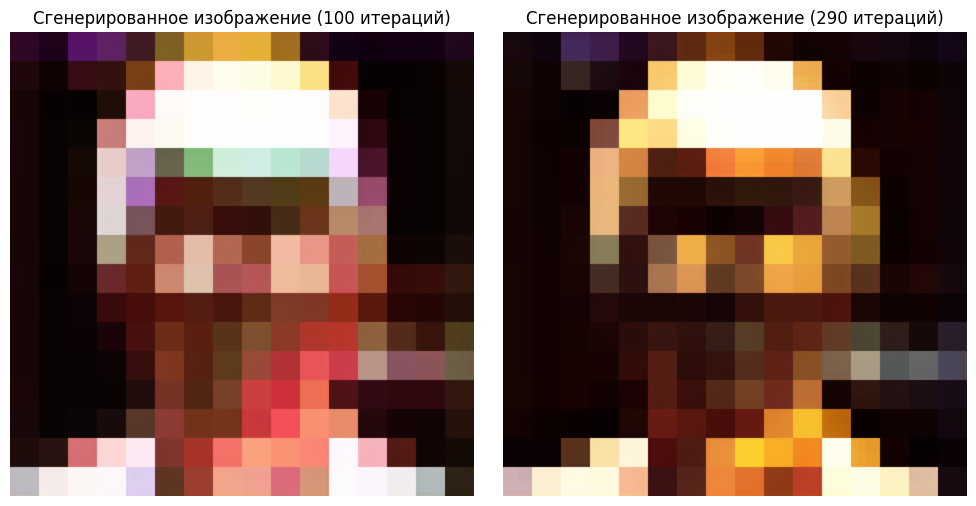

In [35]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title("Сгенерированное изображение (100 итераций)")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title("Сгенерированное изображение (290 итераций)")

plt.tight_layout()
plt.show()

Во втором случае чуть уменьшился шум, изменилась цветовая палитра, но качество генерации не сильно улучшилось

## Этап 3. Дополнительный анализ

В данном разделе рекомендуется провести дополнительные эксперименты и анализ:
- **Анализ латентного пространства**. *(2 балла)*

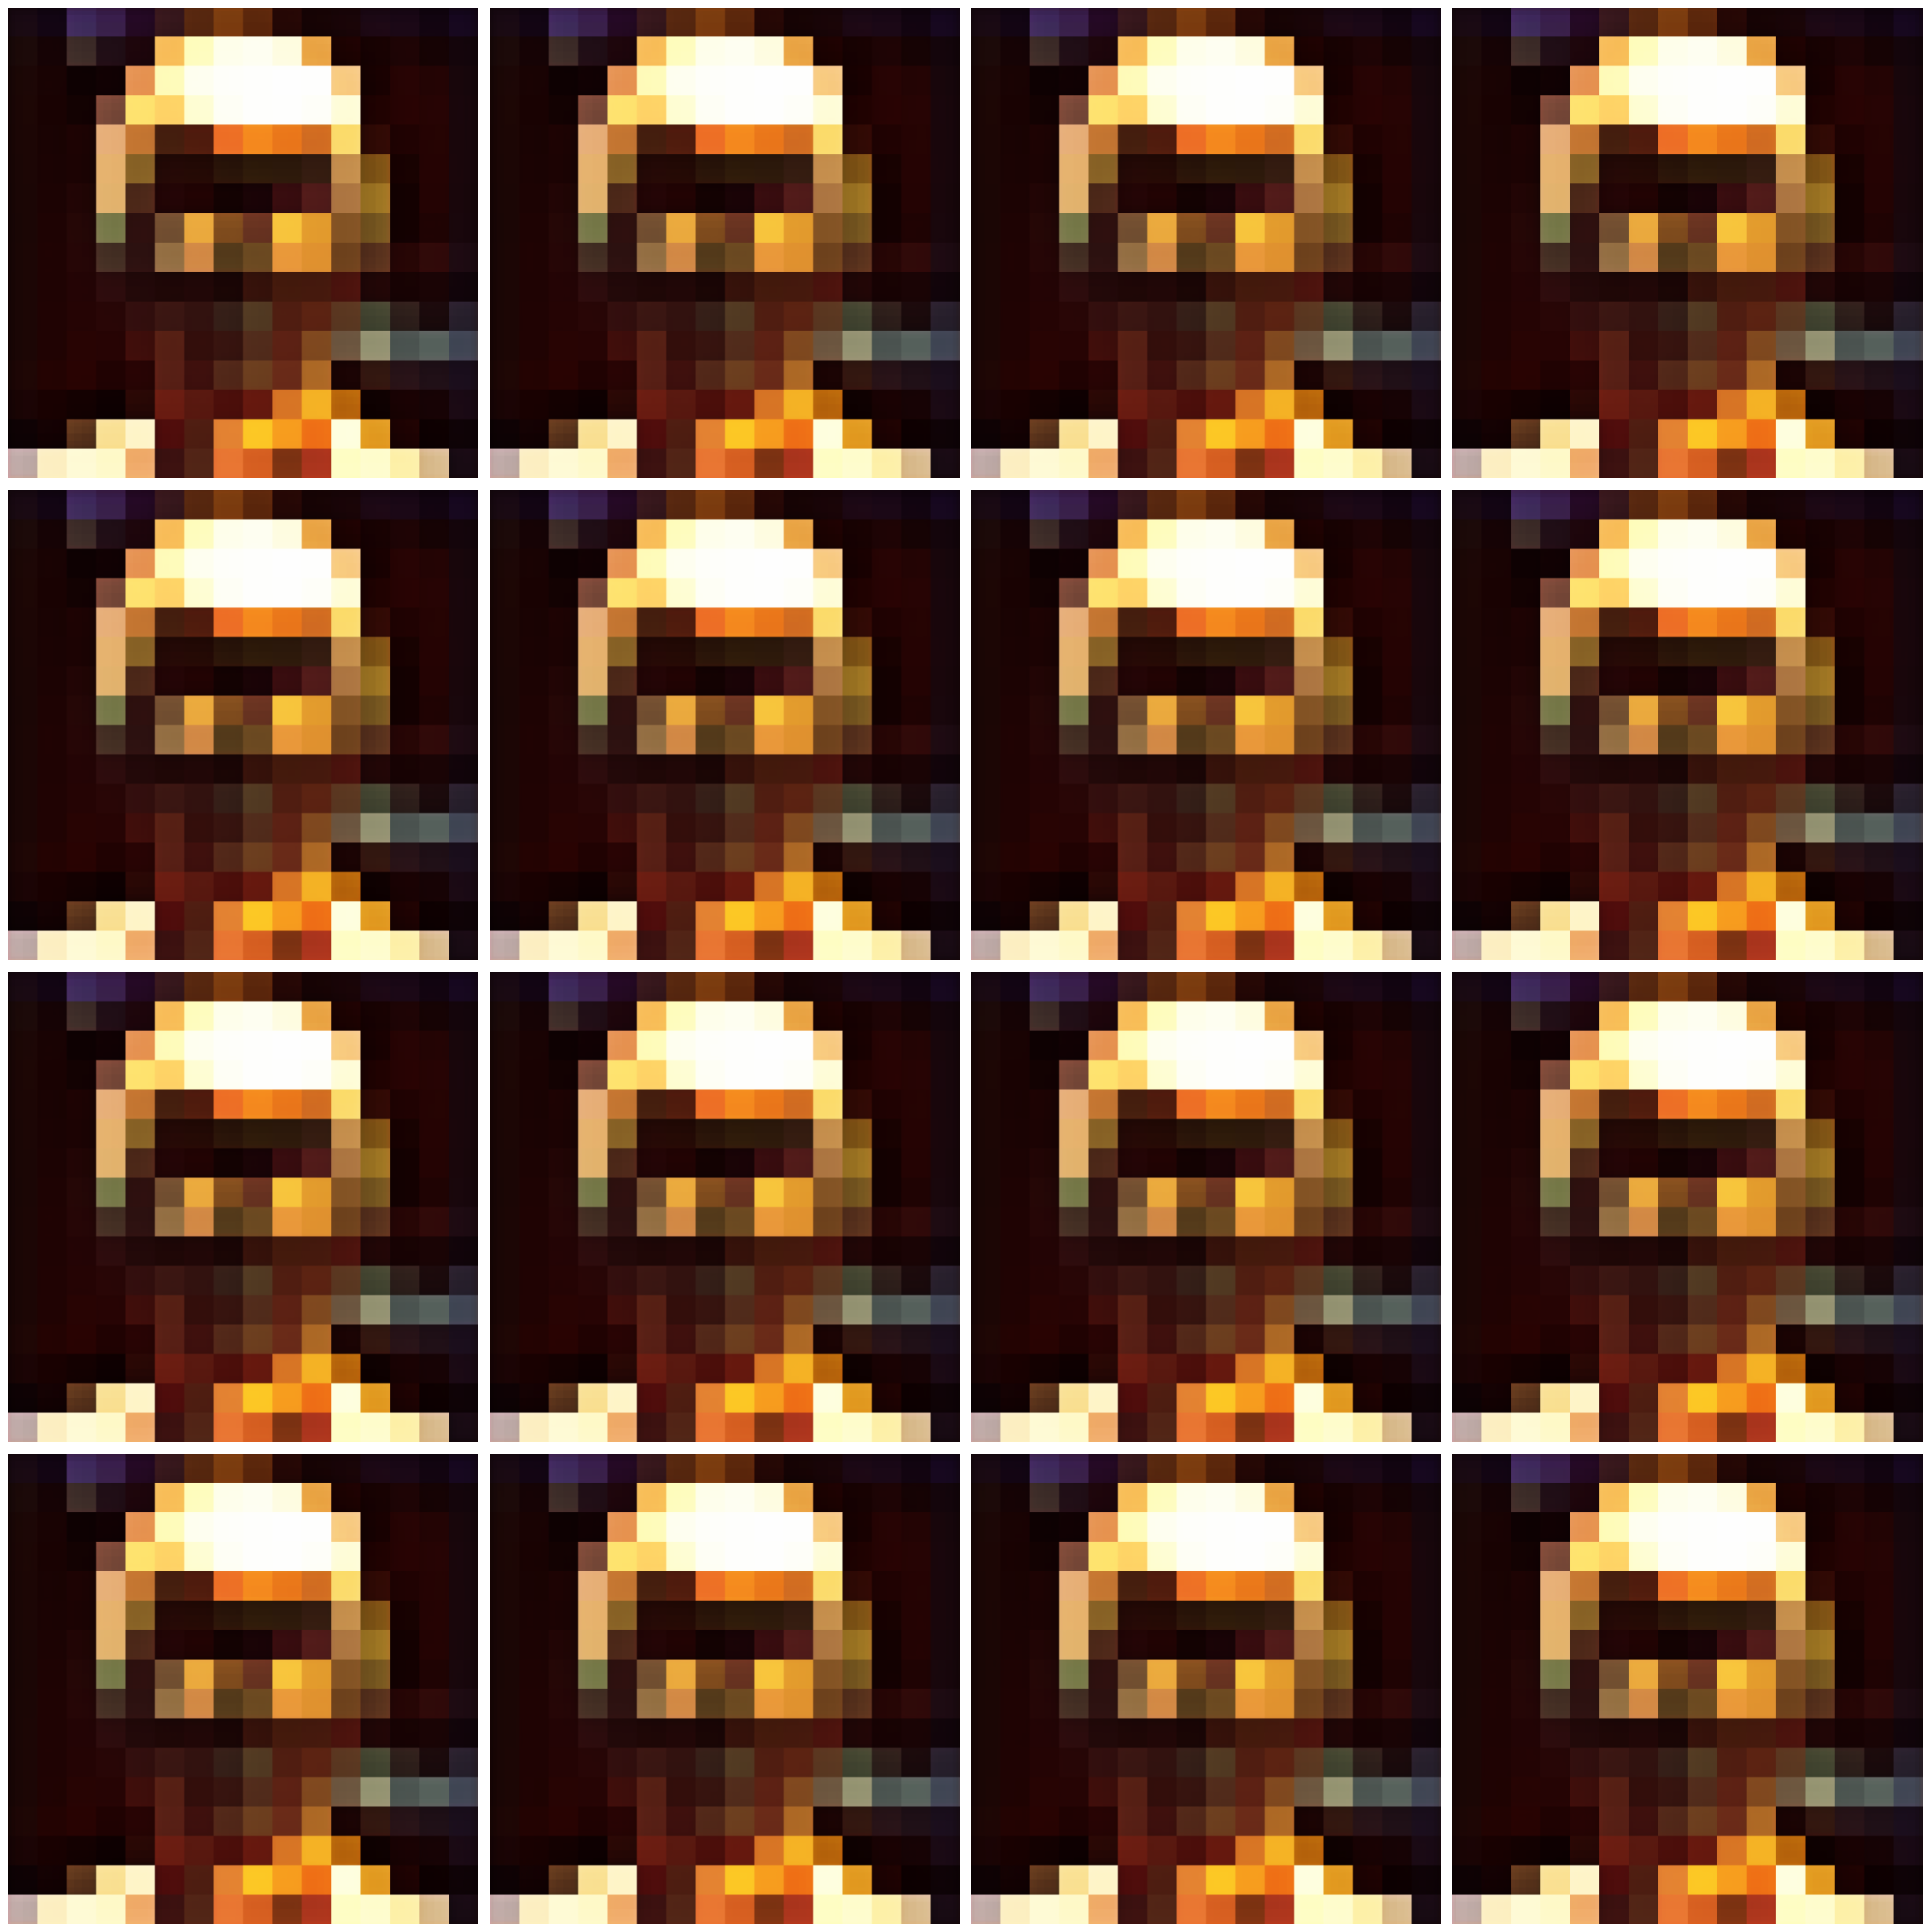

In [45]:
def latent_interpolation(x_real, steps=16):
    x_real = x_real.to(device)

    z1 = torch.randn(1, args.latent_dim).to(device)
    z2 = torch.randn(1, args.latent_dim).to(device)

    imgs = []

    for t in np.linspace(0, 1, steps):
        z = (1 - t) * z1 + t * z2
        s = nets2.mapping_network(z, torch.tensor([0]).to(device))
        with torch.no_grad():
            out = nets2.generator(x_real, s)
        imgs.append(out[0])

    return imgs


imgs = latent_interpolation(x_real)
cols = 4
rows = (len(imgs) + cols - 1) // cols
plt.figure(figsize=(6 * cols, 6 * rows))

for i, img in enumerate(imgs):
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    # print(img.mean())
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Интерполяции между z₁ и z₂ показывают плавные переходы в стилистических признаках лица. В данном случае мы не видим разницу из-за крупных пикселей, свидетельствующих о недообучении генератора

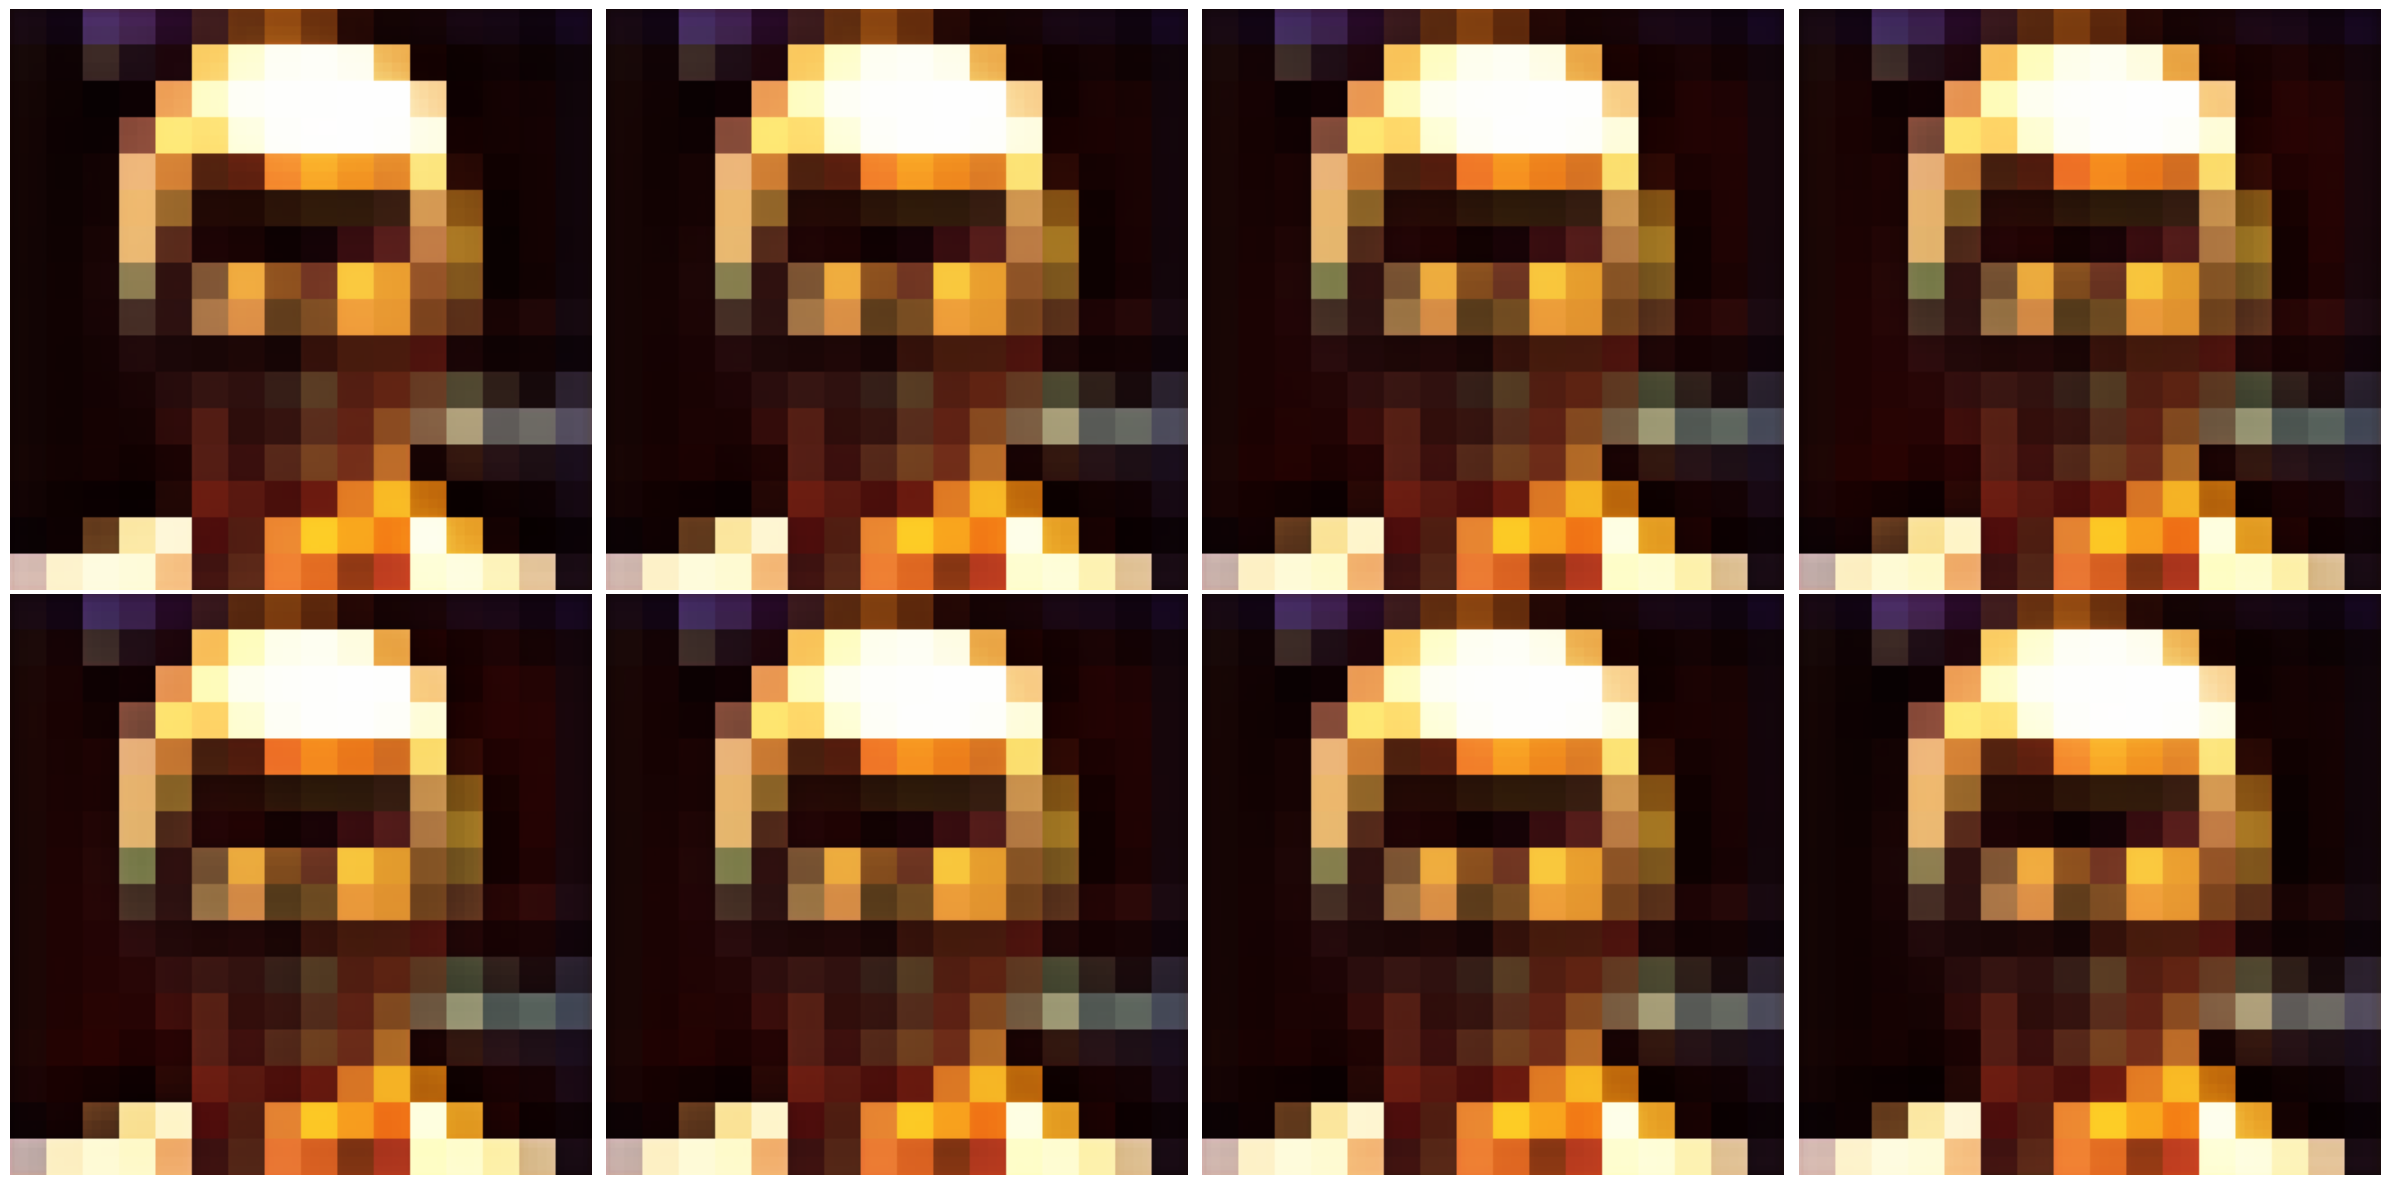

In [48]:
def vary_single_dimension(x_real, dim=0, steps=8, scale=10):
    x_real = x_real.to(device)
    base = torch.zeros(1, args.latent_dim).to(device)

    imgs = []
    for val in np.linspace(-scale, scale, steps):
        z = base.clone()
        z[0, dim] = val
        s = nets2.mapping_network(z, torch.tensor([0]).to(device))
        with torch.no_grad():
            out = nets2.generator(x_real, s)
        imgs.append(out[0])

    return imgs

imgs = vary_single_dimension(x_real, dim=0)
cols = 4
rows = (len(imgs) + cols - 1) // cols
plt.figure(figsize=(6 * cols, 6 * rows))

for i, img in enumerate(imgs):
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Здесь изменение одной координаты z демонстрирует, что каждая компонента отвечает за независимое направление изменения изображения. В данном случае мы можем наблюдать изменение фона

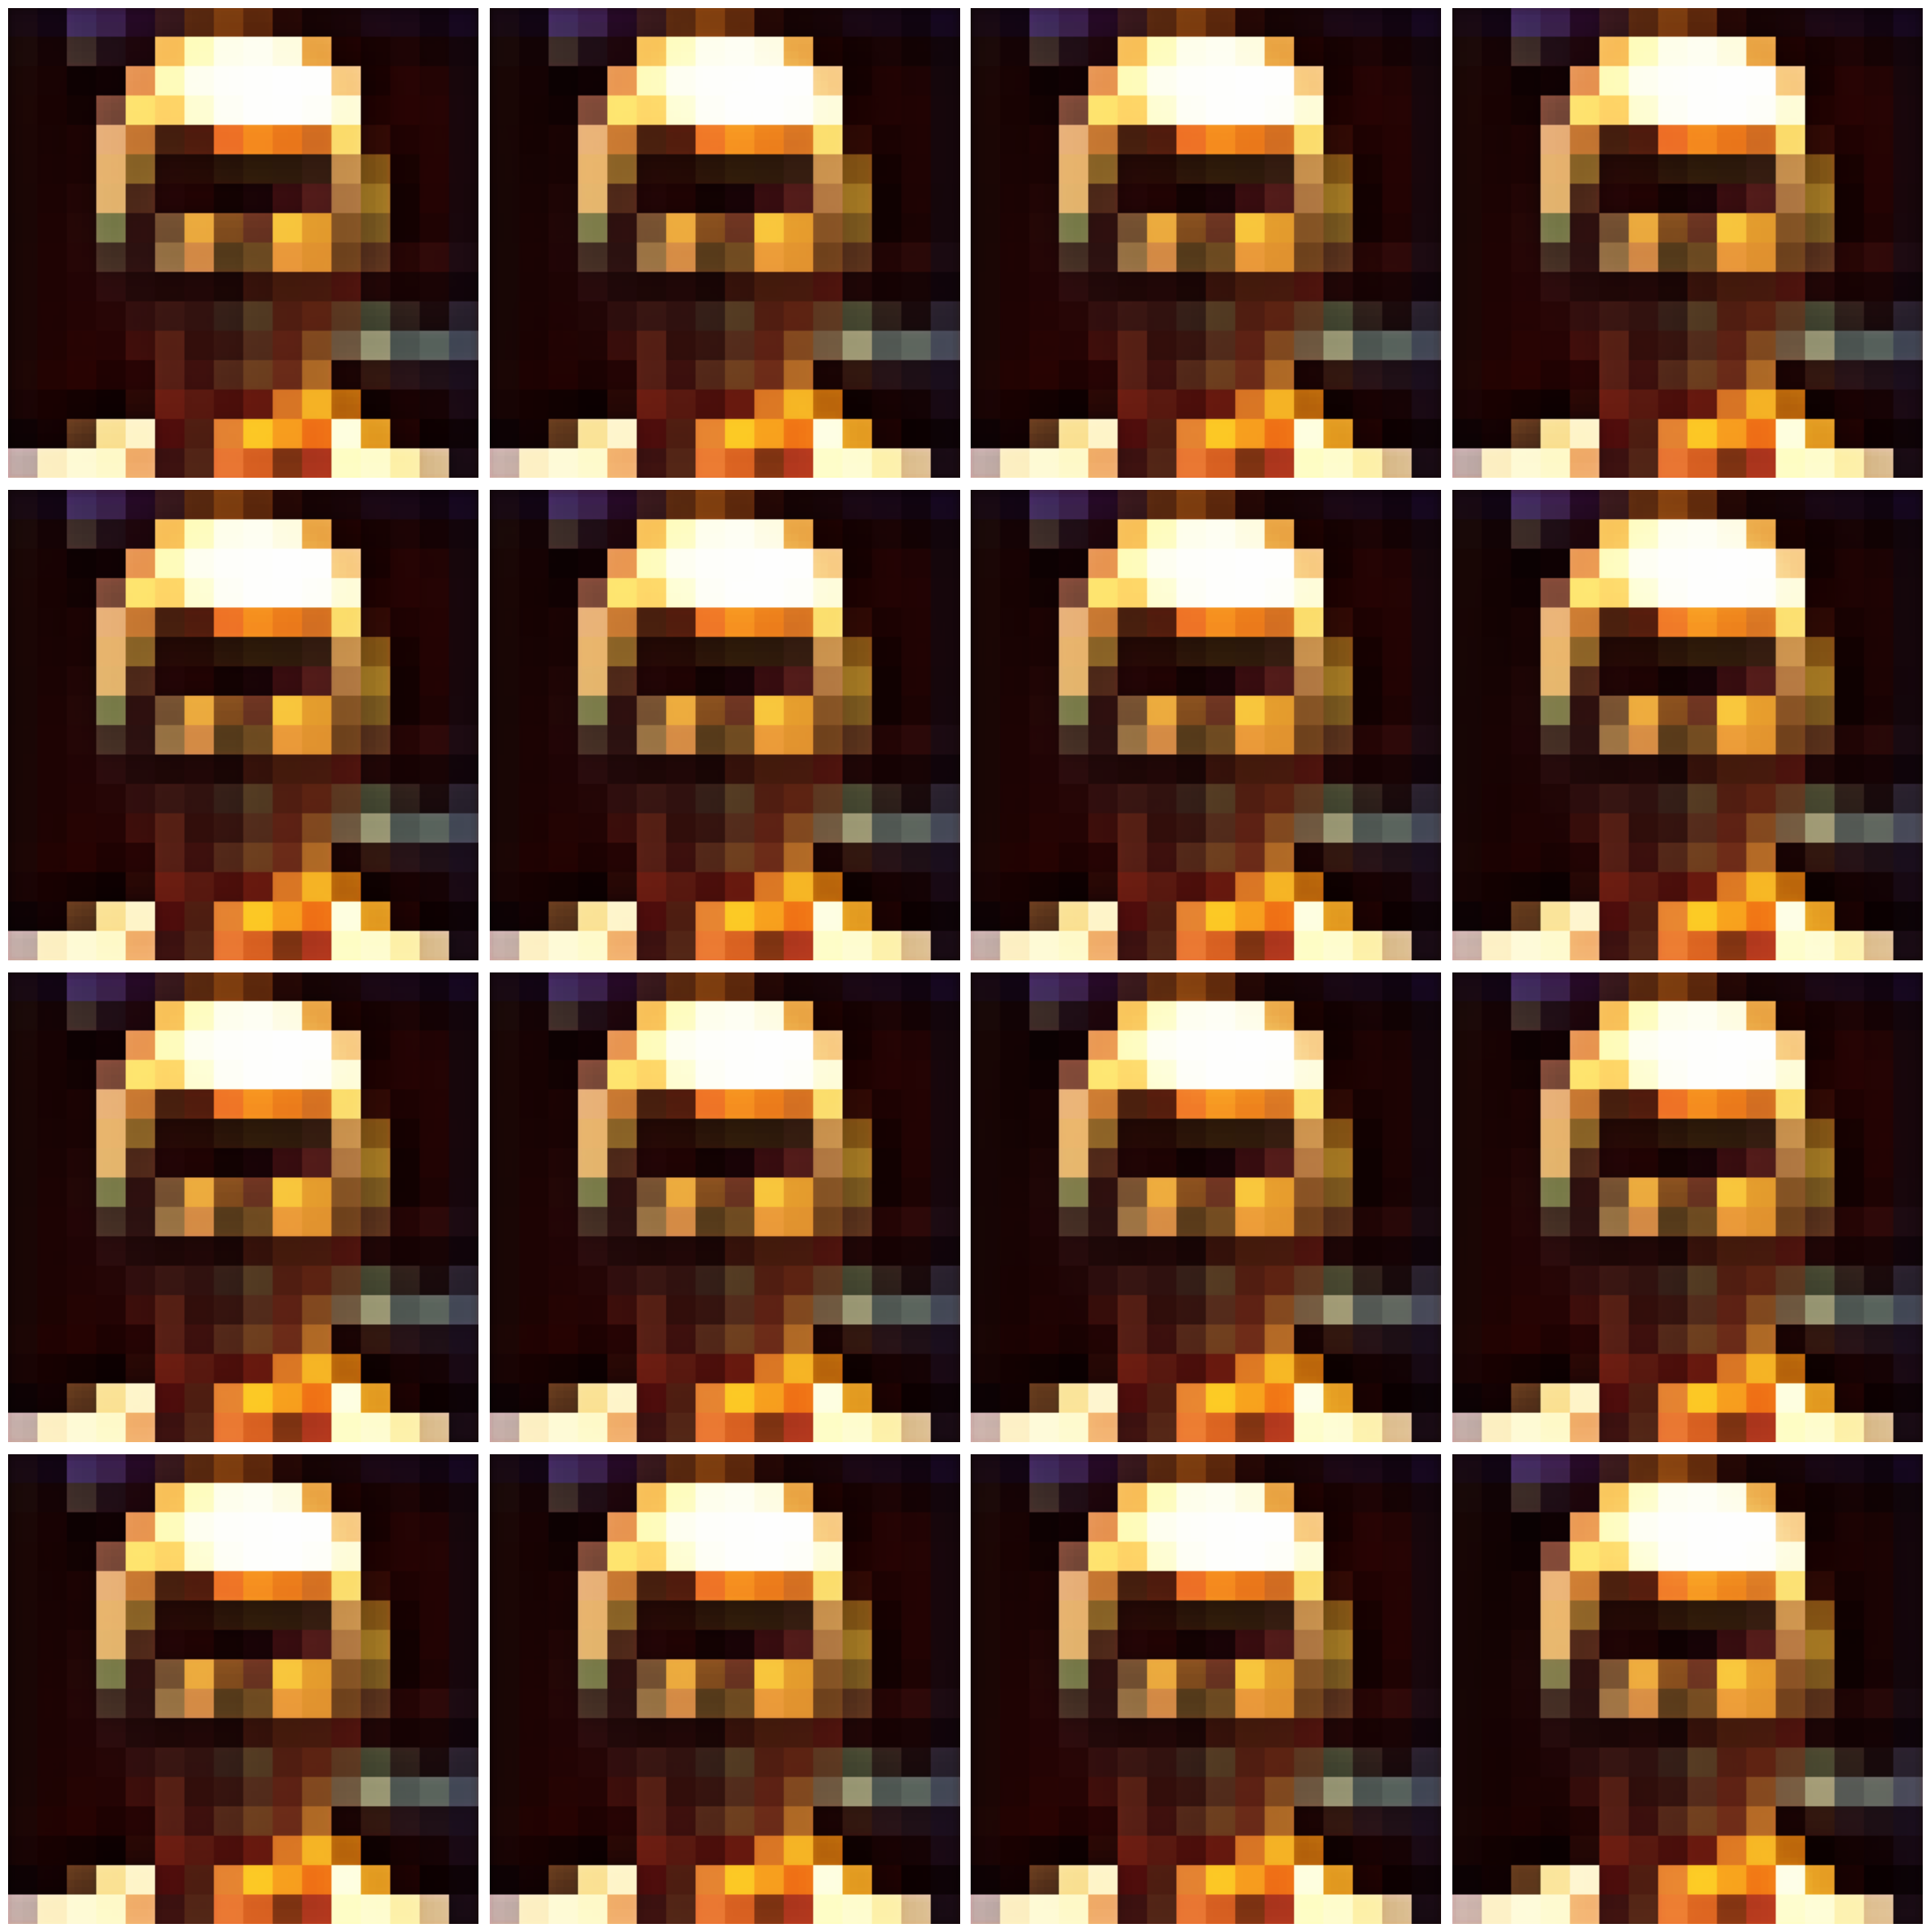

In [49]:
def diversity_demo(x_real, n=16):
    x_real = x_real.to(device)
    imgs = []
    for _ in range(n):
        z = torch.randn(1, args.latent_dim).to(device)
        s = nets2.mapping_network(z, torch.tensor([0]).to(device))
        with torch.no_grad():
            out = nets2.generator(x_real, s)
        imgs.append(out[0])
    return imgs

imgs = diversity_demo(x_real)
cols = 4
rows = (len(imgs) + cols - 1) // cols
plt.figure(figsize=(6 * cols, 6 * rows))

for i, img in enumerate(imgs):
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Здесь мы попробовали сгенерировать разные стили для одного изображения. Опять же, получается не очень наглядно, но где-то мы можем наблюдать изменения в фоне, где-то внизу картинки

- **Текстовое ревью решения**: опишите, какие изменения можно внести для улучшения модели, и обоснуйте их. *(1 балл)*

**Предложения для улучшения модели:**

0. Купить подписку в колабе и обучиться хотя бы на 10% картинок :))
1. Использовать **GroupNorm** вместо InstanceNorm в генераторе и дискриминаторе. GroupNorm одинаково хорошо работает как на больших размерах батча, так и при размере батча = 1, поэтому градиенты станут стабильнее, и генерация получится менее шумной ([источник](https://arxiv.org/abs/1803.08494))
2. **R1-регуляризация** для дискриминатора. Поможет стабилизировать обучение, особенно при малых размерах батчей ([источник](https://arxiv.org/abs/1801.04406))
3. Использовать **перцептуальный лосс** при обучении. Генератор начнет оптимизироваться на основе LPIPS loss, а не только по мнению дискриминатора. Также улучшится identity preservation ([источник](https://arxiv.org/abs/1801.03924))
